In [1]:
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import util
from scipy.fft import fft, ifft, fftfreq, rfft
import pickle
from obspy import UTCDateTime
import scipy.signal as signal
from spectrum import *
from pylab import *
import pandas as pd

In [2]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'

In [3]:
eq_list = os.listdir(root)

client = Client("IRIS")

cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml')

eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])

do_ypcall: clnt_call: RPC: Timed out
do_ypcall: clnt_call: RPC: Timed out
do_ypcall: clnt_call: RPC: Timed out


In [4]:
binned_spectra = [
    [[],[],[],[]],#0-1
    [[],[],[],[]],#1-2
    [[],[],[],[]],#2-3
    [[],[],[],[]],#3-4
    [[],[],[],[]],#4-5
    [[],[],[],[]],#5-6
    [[],[],[],[]],#6-7
    [[],[],[],[]],#7-8
    [[],[],[],[]]#8-9
]

In [5]:
%%script false --no-raise-error
cmap = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
fig, axs = plt.subplots(1,1)
failed = []
for eq_no in range(0, len(eq_with_data[0:100])):
    eq_name = eq_with_data[eq_no]
    try:
        data = obspy.read(root+eq_name+'/data/*/*')
        #data.plot()
        inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
        data.remove_response(inv)
        with open(root+eq_name+'/picks.pkl', 'rb') as f:
            picks = pickle.load(f)
    except: 
        break
    if len(data)>0:
        successful = 0
        for tr_no in range(0, len(data)):
            try:
                sr = data[tr_no].stats.sampling_rate
                tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
                #print(tr_name)
                pick = UTCDateTime(picks[tr_name])
                start = pick #int((pick - data[tr_no].stats.starttime)*sr)
                end = pick + 4 # int(start + 4 * sr)
                d = data[tr_no].copy()#.filter('lowpass', freq=10)
                d.interpolate(100, 'lanczos', a = 20)
                d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
                d.detrend()
                d.integrate()
                d.detrend()
                coda = d.trim(start, end)
                coda.detrend()
                #plt.plot(coda)
                good = 'y'# input()
                if good.lower()[0]=='y':
                    dt = d.stats.delta

                    #creating the frequencies to plot on x axis 
                    Pfreq  = scipy.fft.rfftfreq(len(coda),dt)

                    #doing the multitaper to get the spectra 
                    N = len(coda)
                    NW=0.01*N
                    k=25
                    [tapers, eigen] = dpss(N, NW, k)
                    for eigen_no in range(0, len(eigen)):
                        if eigen[eigen_no] <= 0.5:
                            k = eigen_no
                            break
                    [tapers, eigen] = dpss(N, NW, k)

                    #print(eigen)
                    freq_complex, weights, eigenvalues=pmtm(coda, e=eigen, v=tapers, show=False)
                    freq = abs(freq_complex)
                    freq = np.mean(freq,axis =0)
                    freq_sdv = np.std(freq,axis =0)

                    dist = util.calc_hypo_dist(cat_with_data[eq_no], d, inv)
                    mag = cat_with_data[eq_no].magnitudes[0].mag
                    binned_spectra[int(np.round(mag, 0))][int(dist//50)].append([Pfreq[:-1],freq[0:N//2]])

                    #plotting the spectra in loglog
                    #print('plot')
                    if successful == 0:
                        axs.plot(Pfreq[:-1],freq[0:N//2]-min(freq[0:N//2]), alpha = 0.5, label=str(cat_with_data[eq_no].magnitudes[0].mag), color = cmap[eq_no])#tr_name + data[tr_no].stats.channel)
                    #plt.fill_between(Pfreq[:-1],(Sk+Sk_sdv)[0:N//2],(Sk-Sk_sdv)[0:N//2],alpha=0.2)
                        axs.set_xlabel('Frequency (Hz)');
                        axs.set_ylabel('A^2');
                    #plt.title(tr_name + data[tr_no].stats.channel+' coda wave Power spectra');
                    #else:
                        #axs.plot(Pfreq[:-1],freq[0:N//2]-min(freq[0:N//2]), color = cmap[eq_no], alpha = 0.5)#tr_name + data[tr_no].stats.channel)

                    Pfreq_MHZ = Pfreq
                    freq_MHZ = freq 
                    successful += 1
                else:
                    failed.append([eq_name, tr_name])
            #print(freq_MHZ.shape)
            #plt.show()
            except:
                failed.append([eq_name, tr_name])
axs.legend();
#axs.set_title('M'+str(cat_with_data[eq_no].magnitudes[0].mag) + ' ' + eq_name)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlim(0.5, 50)
#plt.close()


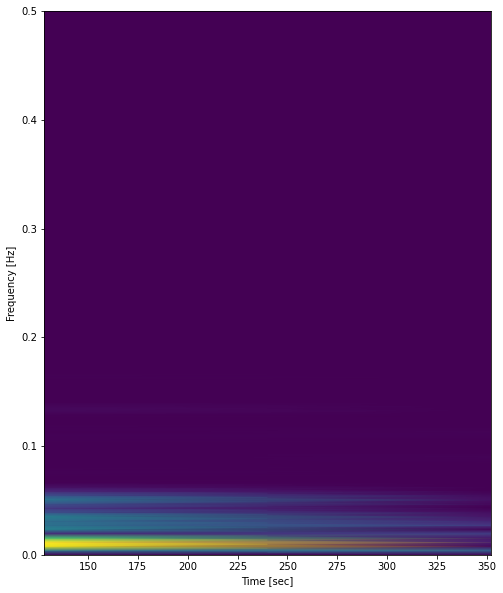

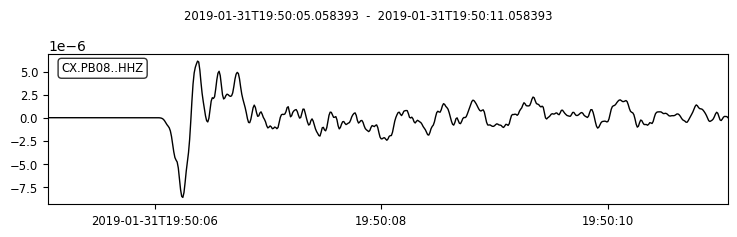

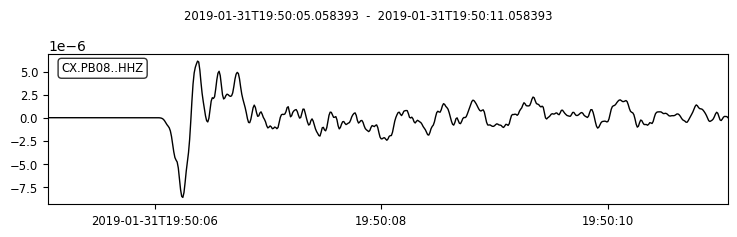

In [11]:
d.plot()

TypeError: cannot unpack non-iterable Axes object

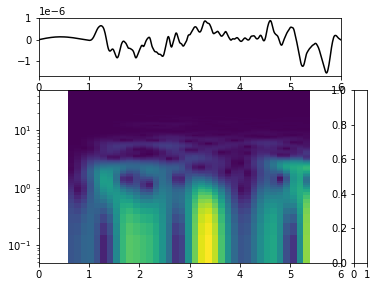

In [112]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

#make time vector
t = np.arange(d.stats.npts) / d.stats.sampling_rate

#plot waveform (top subfigure)    
ax1.plot(t, d.data, 'k')

#plot spectrogram (bottom subfigure)
spl2 = d
f, t, Sxx = spl2.spectrogram(show=False, axes=ax2, log = True)
mappable = ax2.collections[0]
ax2.vlines(1, 0, 50, color='white')
ax2.vlines(5, 0, 50, color='white')
ax2.hlines(1/tpmax, 0, 6, color='hotpink')
ax2.hlines(1/tc, 0, 6, color='skyblue')
plt.colorbar(mappable=mappable, cax=ax3)

TypeError: float() argument must be a string or a number, not 'QuadMesh'

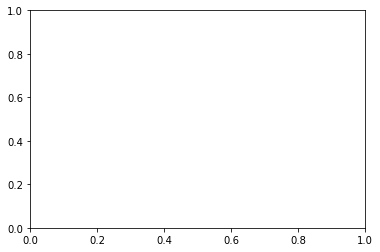

In [111]:
plt.plot(fig.collections[0])

In [8]:
df =  pd.read_pickle('/home/earthquakes1/homes/Rebecca/phd/seismo_det/dataframe_bandpass_3_0_075Hz.pkl')

# actual spectrograms

20190131_194949.a


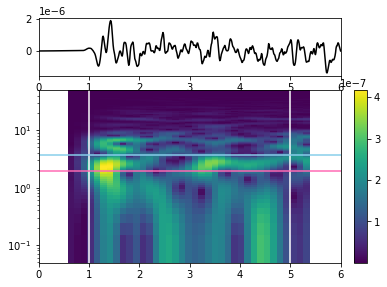

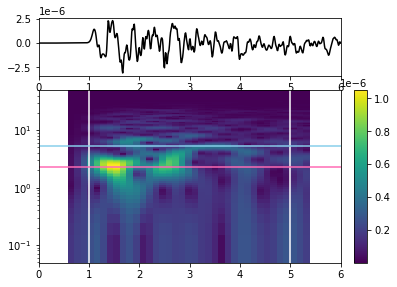

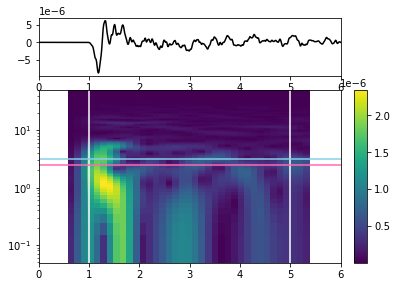

In [9]:
import random 
from datetime import timedelta
for count in range(0, 1):#len(eq_with_data[0:100])):
    eq_no = count # random.randrange(0,len(eq_with_data))
    eq_name = eq_with_data[eq_no]
    Z_comp = 0
    print(eq_name)
    #try:
    data = obspy.read(root+eq_name+'/data/*/*')
    #data.plot()
    inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
    data.remove_response(inv)
    with open(root+eq_name+'/picks.pkl', 'rb') as f:
        picks = pickle.load(f)
    df_row = df.loc[eq_name]
    #except: 
        #continue
    if len(data)>0:
        successful = 0
        for tr_no in range(0, len(data)):
            sr = data[tr_no].stats.sampling_rate
            tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
            #print(tr_name)
            # only consider vertical stations (Z)
            if data[tr_no].stats.channel[-1] == 'Z':
                #try:
                tpmax = df_row.tpmax[Z_comp]
                tc = df_row.tc[Z_comp]

                t = util.filenameToDate(eq_name)
                filter_start = str(UTCDateTime(t-timedelta(seconds=1)))
                filter_stop = str(UTCDateTime(t+timedelta(seconds=1)))

                event = cat.filter('time > ' + filter_start, 'time < ' + filter_stop)
                # print(event)
                data_nearby = util.find_nearby_data(data, inv, event[0], 100)
                #print('pick')
                pick = UTCDateTime(picks[tr_name])
                start = pick -1 #int((pick - data[tr_no].stats.starttime)*sr)
                end = pick + 5 # int(start + 4 * sr)
                #print('d')
                d = data[tr_no].copy()#.filter('lowpass', freq=10)
                d.interpolate(100, 'lanczos', a = 20)
                d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
                d.detrend()
                d.integrate()
                d.detrend()
                d.trim(start, end)
                d.detrend()
                #print('plotting')
                from obspy.imaging.spectrogram import spectrogram
                fig = plt.figure()
                ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
                ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
                ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

                #make time vector
                t = np.arange(d.stats.npts) / d.stats.sampling_rate

                #plot waveform (top subfigure)    
                ax1.plot(t, d.data, 'k')

                #plot spectrogram (bottom subfigure)
                spl2 = d
                fig = spl2.spectrogram(show=False, axes=ax2, log = True)
                mappable = ax2.collections[0]
                ax2.vlines(1, 0, 50, color='white')
                ax2.vlines(5, 0, 50, color='white')
                ax2.hlines(1/tpmax, 0, 6, color='hotpink')
                ax2.hlines(1/tc, 0, 6, color='skyblue')
                plt.colorbar(mappable=mappable, cax=ax3)
                plt.savefig('/home/earthquakes1/homes/Rebecca/phd/data/spectrograms/'+eq_name+'_'+tr_name+'.png')
                Z_comp += 1
                #except:
                #    continue #print('except')
                

# trying to get the data out of one spectrogram
## load one eq of data

In [28]:
for count in range(0, 1):#len(eq_with_data[0:100])):
    eq_no = count # random.randrange(0,len(eq_with_data))
    eq_name = eq_with_data[eq_no]
    Z_comp = 0
    print(eq_name)
    #try:
    data = obspy.read(root+eq_name+'/data/*/*')
    #data.plot()
    inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
    data.remove_response(inv)
    with open(root+eq_name+'/picks.pkl', 'rb') as f:
        picks = pickle.load(f)
    df_row = df.loc[eq_name]
    #except: 
        #continue
    if len(data)>0:
        successful = 0
        for tr_no in range(0, len(data)):
            sr = data[tr_no].stats.sampling_rate
            tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
            #print(tr_name)
            # only consider vertical stations (Z)
            if data[tr_no].stats.channel[-1] == 'Z':
                #try:
                tpmax = df_row.tpmax[Z_comp]
                tc = df_row.tc[Z_comp]

                t = util.filenameToDate(eq_name)
                filter_start = str(UTCDateTime(t-timedelta(seconds=1)))
                filter_stop = str(UTCDateTime(t+timedelta(seconds=1)))

                event = cat.filter('time > ' + filter_start, 'time < ' + filter_stop)
                # print(event)
                data_nearby = util.find_nearby_data(data, inv, event[0], 100)
                #print('pick')
                pick = UTCDateTime(picks[tr_name])
                start = pick -1 #int((pick - data[tr_no].stats.starttime)*sr)
                end = pick + 5 # int(start + 4 * sr)
                #print('d')
                d = data[tr_no].copy()#.filter('lowpass', freq=10)
                d.interpolate(100, 'lanczos', a = 20)
                d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
                d.detrend()
                d.integrate()
                d.detrend()
                d.trim(start, end)
                d.detrend()
                #print('plotting')
                '''from obspy.imaging.spectrogram import spectrogram
                fig = plt.figure()
                ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
                ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
                ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

                #make time vector
                t = np.arange(d.stats.npts) / d.stats.sampling_rate

                #plot waveform (top subfigure)    
                ax1.plot(t, d.data, 'k')

                #plot spectrogram (bottom subfigure)
                spl2 = d
                fig = spl2.spectrogram(show=False, axes=ax2, log = True)
                mappable = ax2.collections[0]
                ax2.vlines(1, 0, 50, color='white')
                ax2.vlines(5, 0, 50, color='white')
                ax2.hlines(1/tpmax, 0, 6, color='hotpink')
                ax2.hlines(1/tc, 0, 6, color='skyblue')
                plt.colorbar(mappable=mappable, cax=ax3)'''



20190131_194949.a


## make spectrogram using matplotlib?

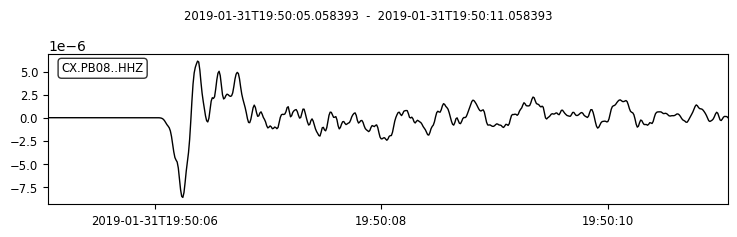

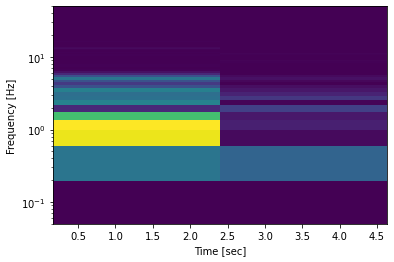

In [31]:
d.plot()                
f, t, Sxx = signal.spectrogram(d.data, 100)
plt.figure()
plt.pcolormesh(t, f, Sxx, shading='nearest')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim([0.05,50])
plt.show()

 that was a mistake

## return to using obspy

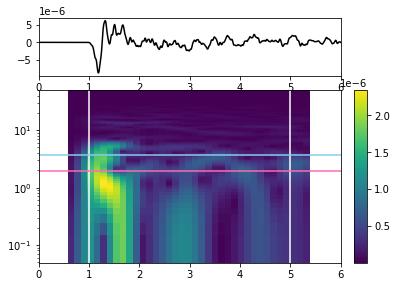

In [21]:
                fig = plt.figure()
                ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
                ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
                ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

                #make time vector
                t = np.arange(d.stats.npts) / d.stats.sampling_rate

                #plot waveform (top subfigure)    
                ax1.plot(t, d.data, 'k')

                #plot spectrogram (bottom subfigure)
                spl2 = d
                fig = spl2.spectrogram(show=False, axes=ax2, log = True)
                mappable = ax2.collections[0]
                ax2.vlines(1, 0, 50, color='white')
                ax2.vlines(5, 0, 50, color='white')
                ax2.hlines(1/tpmax, 0, 6, color='hotpink')
                ax2.hlines(1/tc, 0, 6, color='skyblue')
                plt.colorbar(mappable=mappable, cax=ax3)

the ax2 data is key here -- work out what i can look at from it

In [41]:
ax2.__dict__

{'_stale': True,
 'stale_callback': <function matplotlib.figure._stale_figure_callback(self, val)>,
 '_axes': <Axes:>,
 'figure': <Figure size 432x288 with 3 Axes>,
 '_transform': None,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': False,
 '_agg_filter': None,
 '_mouseover': False,
 '_callbacks': <matplotlib.cbook.CallbackRegistry at 0x7fa89e6dc640>,
 '_remove_method': <bound method FigureBase.delaxes of <Figure size 432x288 with 3 Axes>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 '_position': Bbox([[0.1, 0.1], [0.7999999999999999, 0.7]]),
 '_originalPosition': Bbox([[0.1, 0.1], [0.7999999999999999, 0.7]]),
 '_aspect': 'auto',
 '_adjustable': 'box',
 '_anchor': 'C',
 '_stale_viewlim_x': False,
 '_stale_viewlim_y': False,
 '_

lets name l the ax2.collections option

In [126]:

l = ax2.collections


l[0] is a quadbox or something. what can we find out about that?

In [54]:
l[0].__dict__

{'_stale': False,
 'stale_callback': <function matplotlib.artist._stale_axes_callback(self, val)>,
 '_axes': <Axes:>,
 'figure': <Figure size 432x288 with 3 Axes>,
 '_transform': <matplotlib.transforms.CompositeGenericTransform at 0x7fa89e6dce20>,
 '_transformSet': True,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': <matplotlib.transforms.TransformedBbox at 0x7fa89e6b4340>,
 '_clippath': None,
 '_clipon': True,
 '_label': '_collection0',
 '_picker': None,
 '_contains': None,
 '_rasterized': False,
 '_agg_filter': None,
 '_mouseover': False,
 '_callbacks': <matplotlib.cbook.CallbackRegistry at 0x7fa89e6f1a30>,
 '_remove_method': <function list.remove(value, /)>,
 '_url': None,
 '_gid': None,
 '_snap': True,
 '_sketch': None,
 '_path_effects': None,
 '_sticky_edges': _XYPair(x=[0.57499999999999996, 5.3849999999999998], y=[0.048828125, 50.048828125]),
 '_in_layout': True,
 '_A': masked_array(data = [  2.64301099e-07   6.67474257e-07   1.06554076e-06 ...,   1.5994099

has an amplitude value! 

In [68]:
len(l[0]._A)

18944

and a coordinates option which gives the positions of the corners of the boxes

In [61]:
l[0]._coordinates.shape

(513, 38, 2)

In [84]:
coords = l[0]._coordinates
amp = l[0]._A

In [79]:
len(amp)

18944

we need to ignore the last row and column of coords so that we only consider the lower left corner and put out points there.
that way we have the same number of coordinates and amplitude values

In [92]:
coords_concat = np.array(coords[0][:-1])
for i in range(1, len(coords)-1):
    coords_concat = np.concatenate((coords_concat, coords[i][:-1]))

In [93]:
coords_concat

array([[  5.75000000e-01,   4.88281250e-02],
       [  7.05000000e-01,   4.88281250e-02],
       [  8.35000000e-01,   4.88281250e-02],
       ..., 
       [  4.99500000e+00,   4.99511719e+01],
       [  5.12500000e+00,   4.99511719e+01],
       [  5.25500000e+00,   4.99511719e+01]])

transfer into y and x for plotting

In [107]:
y = []
x = []
for j in coords_concat:
    y.append(j[1])
    x.append(j[0])

each row has 37 values in it

In [112]:
for j in range(0, len(coords_concat), 37):
    print(j, coords_concat[j][0])

0 0.575
37 0.575
74 0.575
111 0.575
148 0.575
185 0.575
222 0.575
259 0.575
296 0.575
333 0.575
370 0.575
407 0.575
444 0.575
481 0.575
518 0.575
555 0.575
592 0.575
629 0.575
666 0.575
703 0.575
740 0.575
777 0.575
814 0.575
851 0.575
888 0.575
925 0.575
962 0.575
999 0.575
1036 0.575
1073 0.575
1110 0.575
1147 0.575
1184 0.575
1221 0.575
1258 0.575
1295 0.575
1332 0.575
1369 0.575
1406 0.575
1443 0.575
1480 0.575
1517 0.575
1554 0.575
1591 0.575
1628 0.575
1665 0.575
1702 0.575
1739 0.575
1776 0.575
1813 0.575
1850 0.575
1887 0.575
1924 0.575
1961 0.575
1998 0.575
2035 0.575
2072 0.575
2109 0.575
2146 0.575
2183 0.575
2220 0.575
2257 0.575
2294 0.575
2331 0.575
2368 0.575
2405 0.575
2442 0.575
2479 0.575
2516 0.575
2553 0.575
2590 0.575
2627 0.575
2664 0.575
2701 0.575
2738 0.575
2775 0.575
2812 0.575
2849 0.575
2886 0.575
2923 0.575
2960 0.575
2997 0.575
3034 0.575
3071 0.575
3108 0.575
3145 0.575
3182 0.575
3219 0.575
3256 0.575
3293 0.575
3330 0.575
3367 0.575
3404 0.575
3441 0.57

now can plot as a scatter graph, colored by amplitude and get basically the same result! 

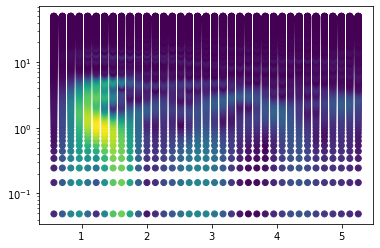

In [121]:
plt.scatter(x,y, c = amp, cmap='viridis')
plt.yscale('log')
#plt.xlim([0.5,1])
#plt.ylim([0,1])

# now onto the actual exercise

we want to sum the columns to work out something which is basically the power

so need to swtich from thinking about rows to columns